# 抽出された特徴量の評価

In [194]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [138]:
import glob
dat = json.load(open("figure_features.json"))
dirname = glob.glob('jsons/*/*')


In [139]:
for shape, d in zip(dat, dirname):
    shape = np.array(shape)
    print d, "\t", shape.mean(0)


jsons/clutter/JPN 	[ 0.0090231   0.015956    0.19622364  0.22991623  0.54888102]
jsons/clutter/WRD 	[ 0.00564449  0.0115223   0.20894616  0.25247929  0.52140776]
jsons/gochagocha/JPN 	[ 0.01105343  0.01282227  0.24220134  0.30147198  0.43245098]
jsons/gochagocha/WRD 	[ 0.0042756   0.00923921  0.17685046  0.26003561  0.54959913]
jsons/kirakira/JPN 	[ 0.00431125  0.00682611  0.1643413   0.29225799  0.53226335]
jsons/kirakira/WRD 	[ 0.00724201  0.01040253  0.18952026  0.28195107  0.51088413]
jsons/murmur/JPN 	[ 0.00614216  0.01296055  0.18426367  0.22417467  0.57245895]
jsons/murmur/WRD 	[ 0.00561452  0.0082686   0.19306318  0.26585678  0.52719691]
jsons/sarasara/JPN 	[ 0.01056206  0.01998984  0.209599    0.19552781  0.56432128]
jsons/sarasara/WRD 	[ 0.01030783  0.01589554  0.20013731  0.23737115  0.53628817]
jsons/twinkle/JPN 	[ 0.01162855  0.02258117  0.22542008  0.19402886  0.54634134]
jsons/twinkle/WRD 	[ 0.01064507  0.01463117  0.19079947  0.23005694  0.55386736]


In [140]:
feat = np.array([np.array(d).mean(0) for d in dat])

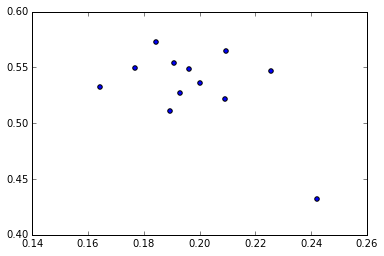

In [141]:
plt.scatter(feat.T[2], feat.T[4])

In [359]:
deg10 = 0.1745

def gen_p_kado():
    return np.pi / 2 + np.random.random() * np.pi / 2

def gen_n_kado():
    return - gen_p_kado()

def gen_p_maru():
    return deg10 + np.random.random() * (np.pi/2 - deg10)

def gen_n_maru():
    return - gen_p_maru()

def gen_massugu():
    return - deg10 + np.random.random() * deg10 * 2

gen_functions = [
    gen_p_kado,
    gen_n_kado,
    gen_p_maru,
    gen_n_maru,
    gen_massugu
    ]


def randomwalk(feat):
    angle = []
    for i in range(100):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_functions[idx]() )
    angle = np.array(angle)
    
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)
    
    return path

def plot_path(path, marker=None):
    size = max(path.max(1) - path.min(1))
    plt.xlim(path.T[0].min(), path.T[0].min() + size)
    plt.ylim(path.T[1].min(), path.T[1].min() + size)    
    plt.subplot(111).set_aspect(1)

    plt.plot(*path.T, marker=marker)    


In [152]:
for f, d in zip(feat, dirname):
    path = randomwalk(f)
    
    plot_path(path)
    
    plt.savefig("random_walk_images/%s.png" % d.replace('/', '_'))
    plt.clf()


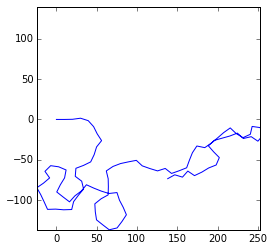

In [156]:
path = randomwalk(feat[2])
plot_path(path)

In [240]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]
norm(scipy.signal.gaussian(20, 5)).sum()

1.0

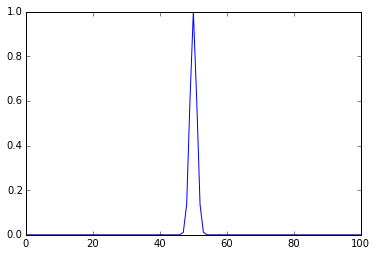

In [358]:
plt.plot( scipy.signal.gaussian(len(path), 1), marker=None )

In [344]:
def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone

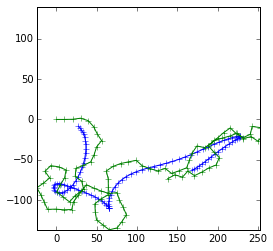

In [370]:
plot_path(gen_bone(path, 5), marker='+')
plot_path(path, marker='+')

In [384]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [474]:
bone = gen_bone(path, 5)
path_edge = path[1:] - path[:-1]
bone_edge = bone[1:] - bone[:-1]

In [475]:
meat = []

for i in range(len(path)-1):
    p = path[i] - bone[i]
    e = bone_edge[i]
    arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
    scale = np.linalg.norm(p) / np.linalg.norm(e)
    meat.append([arg, scale])
    

In [423]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [425]:
circle = gen_circle(len(path), 100)

In [426]:
circle_edge = circle[1:] - circle[:-1]

In [432]:
path_new = []
for i in range(len(path)-1):
    arg, scale = meat[i]
    e = circle_edge[i]
    c = circle[i]
    p = c + rotate(e, arg) * scale
    path_new.append(p)
    
path_new = np.array(path_new)

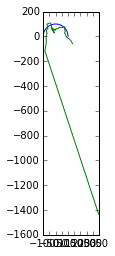

In [473]:
plt.subplot(111).set_aspect(1)
n = 48
plt.plot(*circle[:n].T)
plt.plot(*path_new[:n].T)

array([  9.98107275, -24.21976985])